In [1]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import torch

In [2]:
tego_root = "/mnt/c/data/datasets/TEgO"

In [3]:
embs = torch.load('../tego_embeddings.pt', map_location='cpu')

In [4]:
sys.path.append('../')
from datasets.tego import TEgO
tego_ds: TEgO = TEgO(tego_root)

In [5]:
len(tego_ds), len(embs)

(11930, 11930)

In [6]:
[x for x in dir(tego_ds) if "__" not in x]

['_clear_cache',
 'blind',
 'class_idx',
 'hand',
 'labels',
 'max_opened',
 'non_illuminated',
 'opened',
 'paths',
 'root',
 'testing',
 'torch',
 'transform',
 'unique_labels',
 'volume_portrait',
 'wild']

In [7]:
(tego_ds.testing & (tego_ds.wild == False)).sum()

1710

In [8]:
# mask = (tego_ds.wild == False) & (tego_ds.hand == False) & (tego_ds.blind == False)
mask = np.full(len(tego_ds.class_idx), True)
mask.sum()

11930

In [9]:
mask

array([ True,  True,  True, ...,  True,  True,  True])

In [10]:
import umap.plot
import umap

/mnt/c/Users/crulis/Documents/projects/yolo_tdid/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/c/Users/crulis/Documents/projects/yolo_tdid/venv/lib/python3.8/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [11]:
emb_means = embs.mean(dim=1)
emb_means.shape

torch.Size([11930, 512])

In [12]:
from sklearn.preprocessing import StandardScaler
emb_means_scaled = StandardScaler().fit_transform(emb_means)

In [13]:
# default: min_dist=0.1, spread=1.0
mapper = umap.UMAP(random_state=42, metric="cosine", min_dist=0.5, spread=1.0, n_neighbors=15).fit(emb_means[mask])

/mnt/c/Users/crulis/Documents/projects/yolo_tdid/venv/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<Axes: >

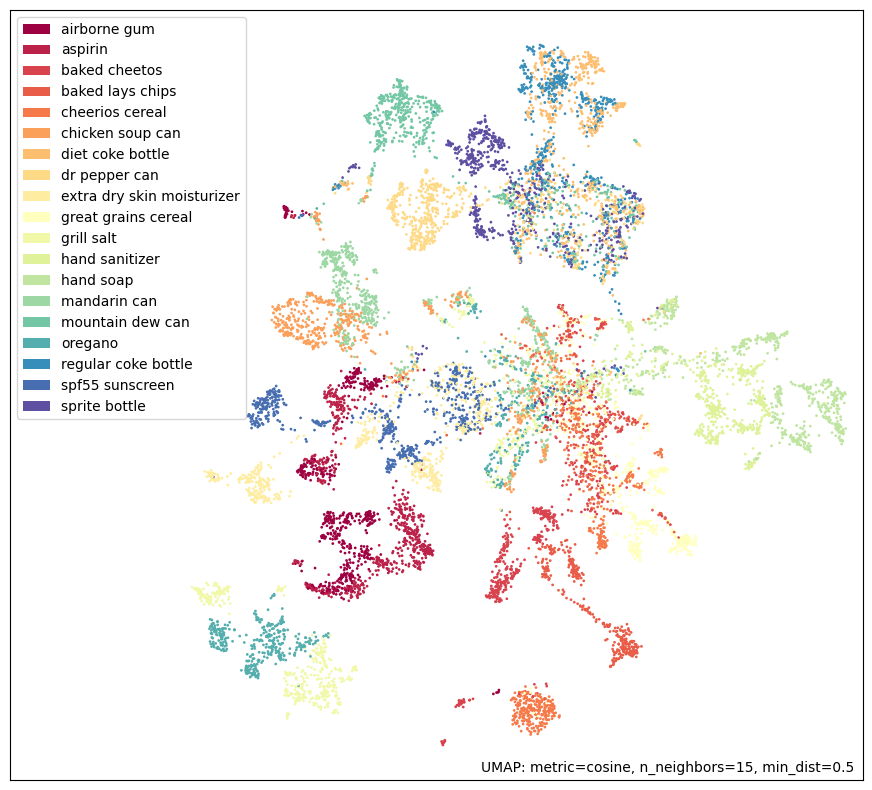

In [74]:
y = np.array(tego_ds.labels)
# y = tego_ds.class_idx

fig, ax = plt.subplots(figsize=(11, 10))
ax.set_xlim(-18.0, 17)
umap.plot.points(mapper, labels=y[mask], width=1500, height=1000, ax=ax)

In [55]:
ax.get_xlim()

(-11.86305832862854, 17.650498628616333)

In [15]:
from sklearn.metrics import silhouette_score
silhouette_score(emb_means[mask], tego_ds.class_idx[mask], metric="cosine")

0.056531644129866346

In [16]:
cls_emb = []
for i in range(19):
    cls_emb.append(emb_means[mask & (tego_ds.class_idx == i)].mean(dim=0))
cls_emb = torch.stack(cls_emb, dim=0)

In [17]:
from models.yolow.utils import get_clip_encoders, get_yolow_clip

In [18]:
img_enc, txt_enc = get_clip_encoders(True)

In [19]:
soap = txt_enc("soap")
text = txt_enc("text")
cylinder = txt_enc("cylinder")
bad_crop = txt_enc("bad crop")
hand = txt_enc("hand")
can = txt_enc("can")

In [20]:
can = txt_enc("can")

In [21]:
juice = txt_enc("juice")

In [22]:
white_foot = txt_enc("white foot")

In [23]:
leprechaun = txt_enc("leprechaun")

In [24]:
barracuda = txt_enc("barracuda")

In [25]:
piano = txt_enc("piano")

In [26]:
white = txt_enc("white")

In [27]:
book = txt_enc("book")

In [28]:
concert_music_inst = txt_enc("concert music instrument")

In [29]:
library = txt_enc("library")

In [30]:
keyboard = txt_enc("keyboard")

In [31]:
bookshelf = txt_enc("bookshelf")

In [32]:
guitar = txt_enc("guitar")

In [33]:
pencil = txt_enc("pencil")
missile = txt_enc("missile")

In [34]:
car = txt_enc("car")

In [35]:
pie = txt_enc("pie")
pic = txt_enc("pic")

In [36]:
tie = txt_enc("tie")

In [37]:
tree = txt_enc("tree")
three = txt_enc("three")

In [38]:
beach = txt_enc("beach")
bleach = txt_enc("bleach")

In [39]:
beach @ bleach.T

tensor([[77.4375]], dtype=torch.float16, grad_fn=<MmBackward0>)

In [40]:
object_ = txt_enc("transparent green plastic sprite bottle")

In [41]:
cls_emb @ object_.T

tensor([[14.5312],
        [14.3281],
        [12.5078],
        [12.6953],
        [12.8672],
        [15.4922],
        [19.1250],
        [18.8750],
        [13.8906],
        [12.5000],
        [16.3125],
        [19.0469],
        [18.4062],
        [16.3906],
        [21.9375],
        [17.1094],
        [19.4688],
        [14.5391],
        [25.0625]], dtype=torch.float16, grad_fn=<MmBackward0>)

In [42]:
cos_sims = torch.cosine_similarity(cls_emb[None, ...], cls_emb[:, None, :], dim=-1).numpy()
cos_sims

array([[    0.99951,     0.97314,     0.87354,     0.88281,     0.84131,     0.91504,     0.85791,     0.85547,     0.88525,     0.88281,     0.92432,     0.89648,     0.88428,     0.91797,     0.83301,     0.91943,     0.85156,     0.91162,     0.85645],
       [    0.97314,           1,     0.85107,     0.85254,     0.80859,     0.89111,     0.83691,      0.8335,     0.88965,     0.85986,     0.89404,     0.89209,     0.86816,     0.89453,     0.81152,     0.89307,     0.83154,     0.91309,     0.83936],
       [    0.87354,     0.85107,     0.99951,     0.97314,     0.92871,     0.92236,     0.87695,     0.89062,     0.87012,      0.9375,     0.91211,     0.86719,     0.85645,      0.9292,       0.875,     0.91553,     0.87744,     0.88184,      0.8833],
       [    0.88281,     0.85254,     0.97314,     0.99902,     0.92871,     0.93311,     0.86914,     0.87354,     0.87256,     0.94873,     0.91699,     0.87061,     0.86328,     0.93604,     0.85889,     0.92139,     0.86963,    

In [43]:
cos_sims.mean(0)

array([    0.89258,     0.87549,     0.90137,     0.90137,     0.87451,     0.92236,     0.90088,     0.90186,     0.88428,     0.90186,     0.91846,     0.90137,     0.89404,     0.92529,     0.88574,     0.91748,     0.89893,     0.89844,     0.90186], dtype=float16)

In [44]:
dot_prods = cls_emb @ cls_emb.T
dot_prods

tensor([[78.3125, 77.9375, 68.5000, 69.9375, 69.0000, 74.5000, 69.8750, 71.8750, 71.0000, 68.1250, 73.9375, 73.8750, 70.8750, 73.4375, 71.6875, 73.7500, 70.1875, 72.6250, 73.5625],
        [77.9375, 81.8750, 68.2500, 69.0000, 67.8125, 74.1250, 69.6250, 71.5000, 72.9375, 67.8750, 73.0625, 75.1250, 71.1250, 73.1875, 71.4375, 73.2500, 70.0625, 74.3750, 73.6875],
        [68.5000, 68.2500, 78.4375, 77.1250, 76.2500, 75.1250, 71.4375, 74.8750, 69.8750, 72.4375, 73.0000, 71.5000, 68.6875, 74.3750, 75.4375, 73.5000, 72.4375, 70.3125, 75.9375],
        [69.9375, 69.0000, 77.1250, 79.9375, 77.0000, 76.7500, 71.5000, 74.1250, 70.7500, 74.0000, 74.0625, 72.5000, 69.9375, 75.6875, 74.7500, 74.6875, 72.4375, 71.3125, 75.8125],
        [69.0000, 67.8125, 76.2500, 77.0000, 85.8750, 76.6875, 72.3750, 75.9375, 69.2500, 76.3125, 73.4375, 71.6250, 70.0000, 75.5000, 76.5625, 74.5625, 73.5625, 69.4375, 76.6875],
        [74.5000, 74.1250, 75.1250, 76.7500, 76.6875, 84.5000, 76.6875, 79.6875, 74.2500, 75.06

In [45]:
dot_prods.mean(0)

tensor([72.2500, 72.4375, 73.0000, 73.7500, 74.1250, 77.6250, 75.8750, 78.3125, 73.3125, 71.9375, 75.8750, 76.7500, 74.0625, 76.5000, 78.9375, 76.0625, 76.6875, 73.9375, 80.1250], dtype=torch.float16)

In [46]:
normalized_emb = cls_emb / dot_prods.mean(0).sqrt()[:, None]

In [47]:
normalized_emb @ normalized_emb.T

tensor([[1.0840, 1.0771, 0.9429, 0.9580, 0.9424, 0.9941, 0.9434, 0.9546, 0.9761, 0.9448, 0.9980, 0.9922, 0.9683, 0.9878, 0.9497, 0.9956, 0.9434, 0.9937, 0.9668],
        [1.0771, 1.1309, 0.9380, 0.9448, 0.9253, 0.9888, 0.9395, 0.9497, 1.0020, 0.9399, 0.9858, 1.0078, 0.9712, 0.9829, 0.9448, 0.9873, 0.9404, 1.0156, 0.9673],
        [0.9429, 0.9380, 1.0732, 1.0508, 1.0361, 0.9971, 0.9600, 0.9893, 0.9546, 0.9985, 0.9805, 0.9546, 0.9336, 0.9946, 0.9937, 0.9868, 0.9678, 0.9565, 0.9927],
        [0.9580, 0.9448, 1.0508, 1.0850, 1.0410, 1.0146, 0.9561, 0.9751, 0.9624, 1.0166, 0.9902, 0.9639, 0.9458, 1.0078, 0.9800, 0.9980, 0.9639, 0.9658, 0.9868],
        [0.9424, 0.9253, 1.0361, 1.0410, 1.1592, 1.0107, 0.9648, 0.9966, 0.9390, 1.0449, 0.9790, 0.9502, 0.9438, 1.0020, 1.0010, 0.9937, 0.9761, 0.9375, 0.9951],
        [0.9941, 0.9888, 0.9971, 1.0146, 1.0107, 1.0879, 0.9995, 1.0215, 0.9844, 1.0039, 1.0342, 1.0059, 0.9893, 1.0654, 1.0225, 1.0449, 1.0000, 0.9927, 1.0166],
        [0.9434, 0.9395, 0.9

In [48]:
normalized_emb.norm(dim=-1)

tensor([1.0410, 1.0635, 1.0361, 1.0410, 1.0762, 1.0430, 1.0557, 1.0713, 1.0586, 1.0283, 1.0371, 1.0625, 1.0518, 1.0332, 1.0957, 1.0391, 1.0635, 1.0459, 1.0840], dtype=torch.float16)

In [49]:
cls_emb.norm(dim=-1)

tensor([8.8516, 9.0469, 8.8594, 8.9453, 9.2656, 9.1953, 9.1953, 9.4844, 9.0625, 8.7188, 9.0312, 9.3047, 9.0547, 9.0391, 9.7266, 9.0625, 9.3125, 9.0000, 9.7031], dtype=torch.float16)